In [1]:
import gym
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env=gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# settings

state_size=env.observation_space.shape[0]
action_size=env.action_space.n
gamma=.95
discount_factor=0.95
LEARNING_RATE=0.01
LEARNING_RATE2=0.1


In [4]:
# Brain


class PolicyApproximator:
    
    def __init__(self):
        
        # Tensorflow settings

        tf.reset_default_graph()
        
        # Building the Network
        
        self.states=tf.placeholder(name='states',shape=[None,state_size],dtype=tf.float32) 
        self.actions=tf.placeholder(name='actions',shape=[None,action_size],dtype=tf.float32)
        self.targets=tf.placeholder(name='target',dtype=tf.float32)
        
        self.layer1=tf.layers.dense(activation=tf.nn.relu,units=10,inputs=self.states)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.layer2=tf.layers.dense(activation=tf.nn.relu,units=2,inputs=self.layer1)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.actions_layer=tf.layers.dense(activation=None,units=action_size,inputs=self.layer2)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        self.softmax_layer=tf.nn.softmax(self.actions_layer)
        self.softmax_layer=tf.squeeze(self.softmax_layer)    # this to change [[]] to []
        
        
       # self.log=tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.actions_layer,labels=self.actions)
        #self.loss=tf.reduce_mean(self.log*self.discounted_reward)
                        
        self.neg_log=tf.reduce_sum(self.actions*-tf.log(self.softmax_layer),axis=1)
        self.loss=tf.reduce_mean(self.neg_log*self.targets)  
        
        self.optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(self.loss)
        
        
        self.init=tf.global_variables_initializer()
        
        self.session=tf.Session()
        self.session.run(self.init)
    
    def predict(self,state):
        
        state=np.reshape(state,newshape=(1,state_size))
        return self.session.run(self.softmax_layer,feed_dict={self.states:state})
        
    
    def train(self,states,targets,actions):

        states=np.reshape(states,newshape=(1,state_size))
  
        _,loss=self.session.run([self.optimizer,self.loss],
                               feed_dict={self.states:states,self.targets:targets,self.actions:actions})
            
        return loss
    
    def close(self):
        self.session.close()

In [5]:
class ValueApproximator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_approximator"):
        with tf.variable_scope(scope):
            self.states = tf.placeholder(tf.float32, [None,state_size], "states")
            self.targets = tf.placeholder(dtype=tf.float32, name="targets")

            # This is just table lookup estimator
            self.layer1=tf.layers.dense(activation=None,units=20,inputs=self.states)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.output_layer=tf.layers.dense(activation=None,units=1,inputs=self.layer1)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
       

            self.loss = tf.squared_difference(self.output_layer, self.targets)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE2).minimize(self.loss) 
            
            
                    
            self.init=tf.global_variables_initializer()
        
            self.session=tf.Session()
            self.session.run(self.init)
    
    def predict(self, states):
        states=np.reshape(states,newshape=(1,state_size))

        return self.session.run(self.output_layer, { self.states: states })

    def train(self, states, targets):
        states=np.reshape(states,newshape=(1,state_size))

        _, loss = self.session.run([self.optimizer, self.loss], feed_dict={ self.states: states, self.targets: targets })
        return loss

In [6]:
policy_approximator=PolicyApproximator()
value_approximator=ValueApproximator()

In [7]:

G=[]
mean_G_all=[]
    
for ep in range(100000):
    episode_rewards=[]
    episode=[]
    
    state=env.reset()
    while True:
        env.render()
        actions_probabilites=policy_approximator.predict(state)
        action = np.random.choice(range(actions_probabilites.shape[0]), p=actions_probabilites.ravel())  # select action w.r.t the actions prob
        
        action_one_hot=np.zeros((1,action_size))
        action_one_hot[:,action]=1  
        
        next_state,reward,done,info=env.step(action)
        
        episode_rewards.append(reward)
        
        # Calculate TD Target
        value_next = value_approximator.predict(next_state)
        td_target = reward + discount_factor * value_next
        td_error = td_target - value_approximator.predict(state)
            
        # Update the value estimator
        value_approximator.train(state, td_target)
            
        # Update the policy estimator
        # using the td error as our advantage estimate
        policy_approximator.train(state, td_error,action_one_hot)
            

        state=next_state    
        
        if done:
            # Calculate sum of the rewards
            episode_rewards_sum = sum(episode_rewards)     
            G.append(episode_rewards_sum)
            total_G = np.sum(G)
            maximumReturn = np.amax(G)
            
            if ep%100==0:
                
                print("==========================================")
                print("Episode: ", ep)
                print("Rewards: ", episode_rewards_sum)
                print("Max reward so far: ", maximumReturn)
                # Mean reward
                mean_G = np.divide(total_G, ep+1)
                mean_G_all.append(mean_G)
                print("Mean Reward", mean_G)
    
            break
            
        

Episode:  0
Rewards:  14.0
Max reward so far:  14.0
Mean Reward 14.0
Episode:  100
Rewards:  9.0
Max reward so far:  14.0
Mean Reward 9.445544554455445
Episode:  200
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.373134328358208
Episode:  300
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.365448504983389
Episode:  400
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.364089775561098
Episode:  500
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.351297405189621
Episode:  600
Rewards:  9.0
Max reward so far:  14.0
Mean Reward 9.32279534109817
Episode:  700
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.322396576319543
Episode:  800
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.3270911360799
Episode:  900
Rewards:  9.0
Max reward so far:  14.0
Mean Reward 9.335183129855716
Episode:  1000
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.340659340659341
Episode:  1100
Rewards:  10.0
Max reward so far:  14.0
Mean Reward 9.347865576748411
Episode:  1

KeyboardInterrupt: 

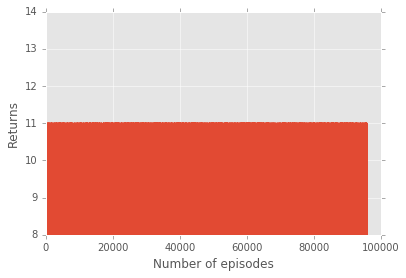

In [8]:
plt.plot(G)
plt.ylabel('Returns')
plt.xlabel('Number of episodes')

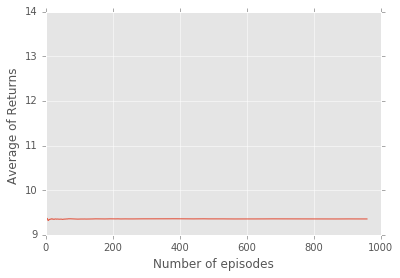

In [9]:
plt.plot(mean_G_all)
plt.ylabel('Average of Returns ')
plt.xlabel('Number of episodes')

In [10]:
plt.plot(episodes_length)
plt.ylabel('Episode Length')
plt.xlabel('Number of Episodes')

NameError: name 'episodes_length' is not defined